## Bibliotecas necessárias

In [48]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import pandas as pd
import mapclassify as mc
from shapely.geometry.point import Point
from matplotlib_scalebar.scalebar import ScaleBar
import hydroeval as he

## Base de dados

#### Camadas de recarga de aquífero do modelo SWAT-MODFLOW

* Atibaia cabeceira
* Camanducaia
* Capivari
* Corumbataí
* Jundiaí

In [49]:
path_atibaia = 'D:/projetos_qswatmod/atibaia_cabeceira/outputs/'
path_camanducaia = 'D:/projetos_qswatmod/camanducaia/outputs/'
path_capivari = 'D:/projetos_qswatmod/capivari/outputs/'
path_corumbatai = 'D:/projetos_qswatmod/corumbatai/outputs/'
path_jundiai = 'D:/projetos_qswatmod/jundiai/outputs/'

#Diretório para salvar as figuras na pasta da tese

path_figuras = 'C:/Users/Wander/OneDrive/Doutorado/tese/figuras/'

In [47]:
#Sub-bacia Atibaia Cabeceira
sub_atibaia_cabeceira = gpd.read_file(path_atibaia + 'mf_rch_monthly.geojson')
limites_atibaia_cabeceira = gpd.read_file(path_atibaia + 'boundary.geojson')

#Sub-bacia Camanducaia
sub_camanducaia = gpd.read_file(path_camanducaia + 'mf_rch_monthly.geojson')
limites_camanducaia = gpd.read_file(path_camanducaia + 'boundary.geojson')

#Sub-bacia Capivari
sub_capivari = gpd.read_file(path_capivari + 'mf_rch_monthly.geojson')
limites_capivari = gpd.read_file(path_capivari + 'boundary.geojson')

#Sub-bacia Corumbatai
sub_corumbatai = gpd.read_file(path_corumbatai + 'mf_rch_monthly.geojson')
limites_corumbatai = gpd.read_file(path_corumbatai + 'boundary.geojson')

#Sub-bacia Jundiai
sub_jundiai = gpd.read_file(path_jundiai + 'mf_rch_monthly.geojson')
limites_jundiai = gpd.read_file(path_jundiai + 'boundary.geojson')

#### Outras camadas necessárias
* Limites das bacias PCJ
* Limites da sub-bacia de Piracicaba
* Limites da sub-bacia de Jaguari

In [4]:
#Camada dos limites da PCJ
limites_pcj = gpd.read_file('D:/projetos_qswatmod/shapes/limite_GCS_WGS84.shp')
limites_pcj = limites_pcj.to_crs(epsg='4674')


#Camada das sub-bacias da PCJ
#PIRACICABA
sub_pira = gpd.read_file('D:/projetos_qswatmod/shapes/sub_piracicaba.geojson')
sub_pira = sub_pira.to_crs(epsg='4674')

#JAGUARI
sub_jaguari = gpd.read_file('D:/projetos_qswatmod/shapes/sub_jaguari.geojson')
sub_jaguari = sub_jaguari.to_crs(epsg='4674')

#ATIBAIA
sub_atibaia = gpd.read_file('D:/projetos_qswatmod/shapes/sub_atibaia.geojson')
sub_atibaia = sub_atibaia.to_crs(epsg='4674')

In [5]:
sub_pira.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### Recortando as camadas de recarga

In [7]:
#Recortando as camadas a partir dos limites da sub-bacia

sub_atibaia_cabeceira = gpd.clip(sub_atibaia_cabeceira, limites_atibaia_cabeceira, keep_geom_type=True)
sub_atibaia_cabeceira.reset_index(drop=True, inplace=True)

sub_camanducaia = gpd.clip(sub_camanducaia, limites_camanducaia, keep_geom_type=True)
sub_camanducaia.reset_index(drop=True, inplace=True)

sub_capivari = gpd.clip(sub_capivari, limites_capivari, keep_geom_type=True)
sub_capivari.reset_index(drop=True, inplace=True)

sub_corumbatai = gpd.clip(sub_corumbatai, limites_corumbatai, keep_geom_type=True)
sub_corumbatai.reset_index(drop=True, inplace=True)

sub_jundiai = gpd.clip(sub_jundiai, limites_jundiai, keep_geom_type=True)
sub_jundiai.reset_index(drop=True, inplace=True)

#### Conversão dos valores de recarga de aquífero e obtenção da média referente ao período de simulação

Os valores de recarga advindos do SWAT-MODFLOW são calculados em $m^3/dia$. Esses valores foram convertidos para **mm/dia** por meio da seguinte equação: <br><br>

- $ R(mm/dia) = {R (m^3/dia) \over 62500} {\times (1000 \times 30.42)} $ <br><br>

    - $ R (mm/dia) $ corresponde à recarga em mm/dia
    - $ R (m^3/dia) $ corresponde à recarga em $m^3/dia$
    - **62500** corresponde à área da célula (250 x 250 m)
    - **1000** para converter de $m^3$ para mm
    - **30.42** para passar de média diária para média mensal. (O MODFLOW faz a média dos dias do respectivo mês e após faz a média dos valores desses dias. Isso gera uma média diária. Deve-se multiplicar por 30.42 para obter a média mensal). <br><br>

[Markdown guide](https://www.markdownguide.org/basic-syntax/)

In [8]:
#ATIBAIA CABECEIRA
df_media_atibaia_cab = sub_atibaia_cabeceira.copy(deep=True)
df_media_atibaia_cab = df_media_atibaia_cab.loc[:, 'Jan-1985': 'Dec-2020']
df_media_atibaia_cab = df_media_atibaia_cab.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
df_media_atibaia_cab['media'] = df_media_atibaia_cab.mean(axis=1)
df_media_atibaia_cab = df_media_atibaia_cab[['media']]
sub_atibaia_cabeceira = pd.concat([sub_atibaia_cabeceira, df_media_atibaia_cab], axis=1)


#CAMANDUCAIA
df_media_camanducaia = sub_camanducaia.copy(deep=True)
df_media_camanducaia = df_media_camanducaia.loc[:, 'Jan-1985': 'Dec-2020']
df_media_camanducaia = df_media_camanducaia.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
df_media_camanducaia['media'] = df_media_camanducaia.mean(axis=1)
df_media_camanducaia = df_media_camanducaia[['media']]
sub_camanducaia = pd.concat([sub_camanducaia, df_media_camanducaia], axis=1)


#CAPIVARI
df_media_capivari = sub_capivari.copy(deep=True)
df_media_capivari = df_media_capivari.loc[:, 'Jan-1985': 'Dec-2020']
df_media_capivari = df_media_capivari.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
df_media_capivari['media'] = df_media_capivari.mean(axis=1)
df_media_capivari = df_media_capivari[['media']]
sub_capivari = pd.concat([sub_capivari, df_media_capivari], axis=1)


#CORUMBATAI
df_media_corumbatai = sub_corumbatai.copy(deep=True)
df_media_corumbatai = df_media_corumbatai.loc[:, 'Jan-1985': 'Dec-2020']
df_media_corumbatai = df_media_corumbatai.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
df_media_corumbatai['media'] = df_media_corumbatai.mean(axis=1)
df_media_corumbatai = df_media_corumbatai[['media']]
sub_corumbatai = pd.concat([sub_corumbatai, df_media_corumbatai], axis=1)


#JUNDIAÍ
df_media_jundiai = sub_jundiai.copy(deep=True)
df_media_jundiai = df_media_jundiai.loc[:, 'Jan-1985': 'Dec-2020']
df_media_jundiai = df_media_jundiai.apply(lambda x: (x / 62500) * (1000 * 30.42), axis=0)
df_media_jundiai['media'] = df_media_jundiai.mean(axis=1)
df_media_jundiai = df_media_jundiai[['media']]
sub_jundiai = pd.concat([sub_jundiai, df_media_jundiai], axis=1)

#### Recarga média

In [9]:
#Cálculo da recarga média

media_atb = sub_atibaia_cabeceira['media'].mean()
media_cmd = sub_camanducaia['media'].mean()
media_cpv = sub_capivari['media'].mean()
media_cbt = sub_corumbatai['media'].mean()
media_jnd = sub_jundiai['media'].mean()

print('Recarga média - modelo MODFLOW \n')
print(f'Atibaia Cab.: {round(media_atb, 1)} \nCamanducaia: {round(media_cmd, 1)} \nCapivari: {round(media_cpv, 1)} \nCorumbataí: {round(media_cbt, 1)} \nJundiaí: {round(media_jnd, 1)}')

Recarga média - modelo MODFLOW 

Atibaia Cab.: 20.8 
Camanducaia: 32.4 
Capivari: 24.7 
Corumbataí: 29.6 
Jundiaí: 16.0


#### Recarga total

In [10]:
minuto = 60
hora = 60 * minuto
dia = 24 * hora
ano_s = 365 * dia

print(f'Um ano tem {ano_s} segundos')

Um ano tem 31536000 segundos


In [11]:
ano = '2020'

print('Recarga total anual em toda a bacia:\n')

#Recarga total anual: ATIBAIA CABECEIRA
df_total = sub_atibaia_cabeceira.copy(deep=True)
df_total = df_total.loc[:, 'Jan-'+ ano: 'Dec-' + ano]
df_total['Total'] = df_total.sum(axis=1)
df_total.loc['Total'] = df_total.sum(axis=0)
total_rec = df_total.iloc[-1, -1]
total_rec_cms = total_rec / ano_s
print(f'ATIBAIA CABECEIRA: {round(total_rec, 0)} m^3/ano ou {round(total_rec_cms, 2)} m^3/s')


#Recarga total anual: CAMANDUCAIA
df_total = sub_camanducaia.copy(deep=True)
df_total = df_total.loc[:, 'Jan-'+ ano: 'Dec-' + ano]
df_total['Total'] = df_total.sum(axis=1)
df_total.loc['Total'] = df_total.sum(axis=0)
total_rec = df_total.iloc[-1, -1]
total_rec_cms = total_rec / ano_s
print(f'CAMANDUCAIA: {round(total_rec, 0)} m^3/ano ou {round(total_rec_cms, 2)} m^3/s')


#Recarga total anual: CAPIVARI
df_total = sub_capivari.copy(deep=True)
df_total = df_total.loc[:, 'Jan-'+ ano: 'Dec-' + ano]
df_total['Total'] = df_total.sum(axis=1)
df_total.loc['Total'] = df_total.sum(axis=0)
total_rec = df_total.iloc[-1, -1]
total_rec_cms = total_rec / ano_s
print(f'CAPIVARI: {round(total_rec, 0)} m^3/ano ou {round(total_rec_cms, 2)} m^3/s')


#Recarga total anual: CORUMBATAÍ
df_total = sub_corumbatai.copy(deep=True)
df_total = df_total.loc[:, 'Jan-'+ ano: 'Dec-' + ano]
df_total['Total'] = df_total.sum(axis=1)
df_total.loc['Total'] = df_total.sum(axis=0)
total_rec = df_total.iloc[-1, -1]
total_rec_cms = total_rec / ano_s
print(f'CORUMBATAÍ: {round(total_rec, 0)} m^3/ano ou {round(total_rec_cms, 2)} m^3/s')


#Recarga total anual: JUNDIAÍ
df_total = sub_jundiai.copy(deep=True)
df_total = df_total.loc[:, 'Jan-'+ ano: 'Dec-' + ano]
df_total['Total'] = df_total.sum(axis=1)
df_total.loc['Total'] = df_total.sum(axis=0)
total_rec = df_total.iloc[-1, -1]
total_rec_cms = total_rec / ano_s
print(f'JUNDIAÍ: {round(total_rec, 0)} m^3/ano ou {round(total_rec_cms, 2)} m^3/s')

Recarga total anual em toda a bacia:

ATIBAIA CABECEIRA: 7628046.0 m^3/ano ou 0.24 m^3/s
CAMANDUCAIA: 4759925.0 m^3/ano ou 0.15 m^3/s
CAPIVARI: 7772645.0 m^3/ano ou 0.25 m^3/s
CORUMBATAÍ: 14529079.0 m^3/ano ou 0.46 m^3/s
JUNDIAÍ: 5119848.0 m^3/ano ou 0.16 m^3/s


#### Alterando o crs da camada de utm para geográficas

In [12]:
#Camada MODFLOW de recarga
sub_atibaia_cabeceira = sub_atibaia_cabeceira.to_crs(epsg='4674')
sub_camanducaia = sub_camanducaia.to_crs(epsg='4674')
sub_capivari = sub_capivari.to_crs(epsg='4674')
sub_corumbatai = sub_corumbatai.to_crs(epsg='4674')
sub_jundiai = sub_jundiai.to_crs(epsg='4674')


#Limites das sub-bacias PCJ
limites_atibaia_cabeceira = limites_atibaia_cabeceira.to_crs(epsg='4674')
limites_camanducaia = limites_camanducaia.to_crs(epsg='4674')
limites_capivari = limites_capivari.to_crs(epsg='4674')
limites_corumbatai = limites_corumbatai.to_crs(epsg='4674')
limites_jundiai = limites_jundiai.to_crs(epsg='4674')

#### Estabelecendo as classes de recarga

In [13]:
"""
Foi definido que serão usadas as mesmas faixas de valores para todas as sub-bacias da PCJ.
Essas faixas (classes) foram definidas se baseando no método de classificação de dados "Natural breaks"

[15, 30, 45, 1000]

"""

#Definindo as faixas de valores e seus respectivos rótulos
referencia = [15, 30, 45, 10000]
labels = ['0 - 15', '15 - 30', '30 - 45', '> 45']

#ATIBAIA CABECEIRA
valores = sub_atibaia_cabeceira['media']
classdef = mc.UserDefined(valores, referencia)
cl = [labels[i] for i in classdef.yb]
sub_atibaia_cabeceira = sub_atibaia_cabeceira.assign(cl=cl)
sub_atibaia_cabeceira.cl = pd.Categorical(sub_atibaia_cabeceira.cl, ordered=True, categories=labels)


#CAMANDUCAI
valores = sub_camanducaia['media']
classdef = mc.UserDefined(valores, referencia)
cl = [labels[i] for i in classdef.yb]
sub_camanducaia = sub_camanducaia.assign(cl=cl)
sub_camanducaia.cl = pd.Categorical(sub_camanducaia.cl, ordered=True, categories=labels)


#CAPIVARI
valores = sub_capivari['media']
classdef = mc.UserDefined(valores, referencia)
cl = [labels[i] for i in classdef.yb]
sub_capivari = sub_capivari.assign(cl=cl)
sub_capivari.cl = pd.Categorical(sub_capivari.cl, ordered=True, categories=labels)


#CORUMBATAÍ
valores = sub_corumbatai['media']
classdef = mc.UserDefined(valores, referencia)
cl = [labels[i] for i in classdef.yb]
sub_corumbatai = sub_corumbatai.assign(cl=cl)
sub_corumbatai.cl = pd.Categorical(sub_corumbatai.cl, ordered=True, categories=labels)


#CAPIVARI
valores = sub_jundiai['media']
classdef = mc.UserDefined(valores, referencia)
cl = [labels[i] for i in classdef.yb]
sub_jundiai = sub_jundiai.assign(cl=cl)
sub_jundiai.cl = pd.Categorical(sub_jundiai.cl, ordered=True, categories=labels)

#### Cores para as respectivas classes

In [14]:
#Lista de cores

colors = ['#c8e59b', '#79c677', '#278042', '#00381d']    # Tons de verde alternativos --> ['#92D050', '#5AC135', '#007600', '#0E3A13']
n_bins = 4
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

#### Criando a var distance_meters para plotar a escala cartográfica

In [15]:
#Calculando a distância entre dois pontos de longitude diferentes para criar a escala cartográfica

points = gpd.GeoSeries([Point(-48.4, -22.8), Point(-45.9, -22.8)], crs=4674)    #  --> Geographic WGS 84 - degrees
points = points.to_crs(32723)    #  --> Projected WGS 84 - meters

distance_meters = points[0].distance(points[1])
print(f'Distância:\n\n{round(distance_meters, 2)} m\nou\n{round(distance_meters / 1000, 2)} km')

Distância:

256748.56 m
ou
256.75 km


#### Mapa de recarga de aquífero - Modelo MODFLOW

talvez a unidade da recarga deva ser mm/mês

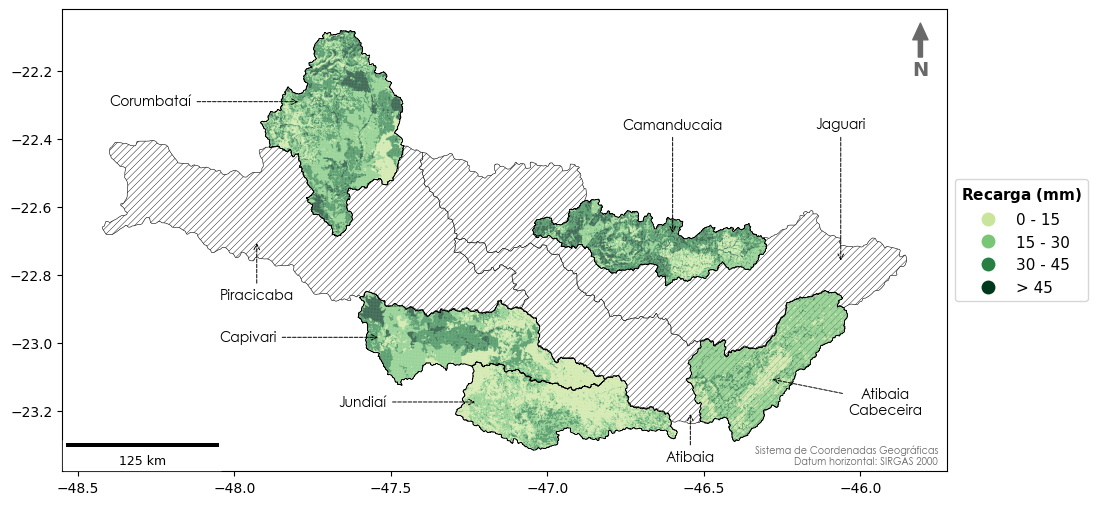

In [16]:
#Configurando a figura
fig, ax = plt.subplots(figsize=(12, 6))

lw = 0.5
######################################################################

#ATIBAIA CABECEIRA
sub_atibaia_cabeceira.plot(ax=ax, column='cl', cmap=cmap, legend=True, legend_kwds={'title': '$\\bf{Recarga _ (mm)}$',
                                                                                    'title_fontsize': 11,
                                                                                    'loc': 'center left',
                                                                                    'bbox_to_anchor': (1.0, 0.5),
                                                                                    'fontsize': 11,
                                                                                    'fmt': '{:.1f}',
                                                                                    'frameon': True}, zorder=1, alpha=1.0)
#Limites Atibaia Cabeceira
limites_atibaia_cabeceira.boundary.plot(ax=ax, color='k', lw=lw, ls='-', label='Limites', zorder=2)


#CAMANDUCAIA E LIMITES
sub_camanducaia.plot(ax=ax, column='cl', cmap=cmap, zorder=1)
limites_camanducaia.boundary.plot(ax=ax, color='k', lw=lw, ls='-', label='Limites', zorder=2)


#CAPIVARI E LIMITES
sub_capivari.plot(ax=ax, column='cl', cmap=cmap, zorder=1)
limites_capivari.boundary.plot(ax=ax, color='k', lw=lw, ls='-', label='Limites', zorder=2)


#CORUMBATAÍ E LIMITES
sub_corumbatai.plot(ax=ax, column='cl', cmap=cmap, zorder=1)
limites_corumbatai.boundary.plot(ax=ax, color='k', lw=lw, ls='-', label='Limites', zorder=2)


#JUNDIAI E LIMITES
sub_jundiai.plot(ax=ax, column='cl', cmap=cmap, zorder=1)
limites_jundiai.boundary.plot(ax=ax, color='k', lw=lw, ls='-', label='Limites', zorder=2)


#Limites da PCJ
# limites_pcj.boundary.plot(ax=ax, edgecolor='k', lw=lw, ls='-', label='Limites PCJ', zorder=0)    #facecolor='w', hatch='////',

plt.rcParams['hatch.linewidth'] = 0.3
subs_lw = 0.4
subs_hatch = '/////'
sub_pira.plot(ax=ax, facecolor='w', edgecolor='k', lw=subs_lw, hatch=subs_hatch, zorder=0)
sub_jaguari.plot(ax=ax, facecolor='w', edgecolor='k', lw=subs_lw, hatch=subs_hatch, zorder=0)
sub_atibaia.plot(ax=ax, facecolor='w', edgecolor='k', lw=subs_lw, hatch=subs_hatch, zorder=0)


#Plotando os LABELS das sub-bacias
arrowprops = dict(arrowstyle='->', color='k', lw=0.7, ls='--')
color, size, fontweight, fontname, alpha = 'k', 10, 'light', 'Century Gothic', 1.0

ax.annotate(text='Piracicaba', xy=(0.22, 0.50), xytext=(0.22, 0.38), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Capivari', xy=(0.36, 0.29), xytext=(0.21, 0.29), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Jundiaí', xy=(0.47, 0.15), xytext=(0.34, 0.15), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Corumbataí', xy=(0.27, 0.8), xytext=(0.1, 0.8), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Camanducaia', xy=(0.69, 0.51), xytext=(0.69, 0.75), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Jaguari', xy=(0.88, 0.45), xytext=(0.88, 0.75), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Atibaia\nCabeceira', xy=(0.80, 0.20), xytext=(0.93, 0.15), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Atibaia', xy=(0.71, 0.13), xytext=(0.71, 0.03), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)

#Texto SRC
plt.text(0.99, 0.01, 'Sistema de Coordenadas Geográficas\nDatum horizontal: SIRGAS 2000', transform=ax.transAxes, va='bottom', ha='right', color='k', fontsize=7, fontweight='light', fontname='Century Gothic', alpha=0.6)

#Seta do Norte
x, y, arrow_length = 0.97, 0.97, 0.10
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='dimgray', edgecolor='dimgray', width=3, headwidth=11),
            ha='center', va='center', fontsize=14, color='dimgray', weight='bold',
            xycoords=ax.transAxes)

#Escala cartográfica
scalebar = ScaleBar(distance_meters, location='lower left', font_properties={'size': 9})
ax.add_artist(scalebar)


#Salvando o mapa
plt.savefig(path_figuras + 'figura_2_3.png', facecolor='w', bbox_inches='tight', dpi=300)

#Visualizando o mapa
plt.show()

## Dados de recarga de aquífero - Modelo SWAT

In [17]:
#Camadas SWAT
atibaia_cabec_swat = gpd.read_file(path_atibaia + 'rch_swat.geojson')
camanducaia_swat = gpd.read_file(path_camanducaia + 'rch_swat.geojson')
capivari_swat = gpd.read_file(path_capivari + 'rch_swat.geojson')
corumbatai_swat = gpd.read_file(path_corumbatai + 'rch_swat.geojson')
jundiai_swat = gpd.read_file(path_jundiai + 'rch_swat.geojson')

In [18]:
atibaia_cabec_swat = atibaia_cabec_swat.to_crs(epsg='4674')
camanducaia_swat = camanducaia_swat.to_crs(epsg='4674')
capivari_swat = capivari_swat.to_crs(epsg='4674')
corumbatai_swat = corumbatai_swat.to_crs(epsg='4674')
jundiai_swat = jundiai_swat.to_crs(epsg='4674')

In [19]:
#Limites estabelecidos --> ATIBAIA CABECEIRA
rec_atibaia = atibaia_cabec_swat['GW_RCHGmm']

classdef_atibaia = mc.UserDefined(rec_atibaia, referencia)
cl_atibaia = [labels[i] for i in classdef_atibaia.yb]
atibaia_cabec_swat = atibaia_cabec_swat.assign(cl_atibaia=cl_atibaia)
atibaia_cabec_swat.cl_atibaia = pd.Categorical(atibaia_cabec_swat.cl_atibaia, ordered=True, categories=labels)


#Limites estabelecidos --> CAMANDUCAIA
rec_camanducaia = camanducaia_swat['GW_RCHGmm']

classdef_camanducaia = mc.UserDefined(rec_camanducaia, referencia)
cl_camanducaia = [labels[i] for i in classdef_camanducaia.yb]
camanducaia_swat = camanducaia_swat.assign(cl_camanducaia=cl_camanducaia)
camanducaia_swat.cl_camanducaia = pd.Categorical(camanducaia_swat.cl_camanducaia, ordered=True, categories=labels)


#Limites estabelecidos --> CAPIVARI
rec_capivari = capivari_swat['GW_RCHGmm']

classdef_capivari = mc.UserDefined(rec_capivari, referencia)
cl_capivari = [labels[i] for i in classdef_capivari.yb]
capivari_swat = capivari_swat.assign(cl_capivari=cl_capivari)
capivari_swat.cl_capivari = pd.Categorical(capivari_swat.cl_capivari, ordered=True, categories=labels)


#Limites estabelecidos --> CORUMBATAÍ
rec_corumbatai = corumbatai_swat['GW_RCHGmm']

classdef_corumbatai = mc.UserDefined(rec_corumbatai, referencia)
cl_corumbatai = [labels[i] for i in classdef_corumbatai.yb]
corumbatai_swat = corumbatai_swat.assign(cl_corumbatai=cl_corumbatai)
corumbatai_swat.cl_corumbatai = pd.Categorical(corumbatai_swat.cl_corumbatai, ordered=True, categories=labels)


#Limites estabelecidos --> JUNDIAÍ
rec_jundiai = jundiai_swat['GW_RCHGmm']

classdef_jundiai = mc.UserDefined(rec_jundiai, referencia)
cl_jundiai = [labels[i] for i in classdef_jundiai.yb]
jundiai_swat = jundiai_swat.assign(cl_jundiai=cl_jundiai)
jundiai_swat.cl_jundiai = pd.Categorical(jundiai_swat.cl_jundiai, ordered=True, categories=labels)

In [20]:
atibaia_cabec_swat.head(2)

,Subbasin,LANDUSE,SOIL,SLOPE_BAND,AREA (ha),%SUBBASIN,HRUGIS,GW_RCHGmm,geometry,cl_atibaia
0,1,FRSE,RL1,0-3.0,8.0,0.006967,10001,53.870525,"MULTIPOLYGON (((-46.1468 -22.86112, -46.1468 -...",> 45
1,1,FRSE,RL1,3.0-8.0,15.0,0.013143,10002,53.121273,"MULTIPOLYGON (((-46.14655 -22.86627, -46.14655...",> 45


#### Cálculo da recarga média - modelo SWAT

In [21]:
#Cálculo da recarga média

media_atb_s = atibaia_cabec_swat['GW_RCHGmm'].mean()
media_cmd_s = camanducaia_swat['GW_RCHGmm'].mean()
media_cpv_s = capivari_swat['GW_RCHGmm'].mean()
media_cbt_s = corumbatai_swat['GW_RCHGmm'].mean()
media_jnd_s = jundiai_swat['GW_RCHGmm'].mean()

print('Recarga média - modelo SWAT \n')
print(f'Atibaia Cab.: {round(media_atb_s, 1)} \nCamanducaia: {round(media_cmd_s, 1)} \nCapivari: {round(media_cpv_s, 1)} \nCorumbataí: {round(media_cbt_s, 1)} \nJundiaí: {round(media_jnd_s, 1)}')

Recarga média - modelo SWAT 

Atibaia Cab.: 23.8 
Camanducaia: 28.8 
Capivari: 23.5 
Corumbataí: 26.1 
Jundiaí: 15.5


#### Mapa de recarga de aquífero - SWAT

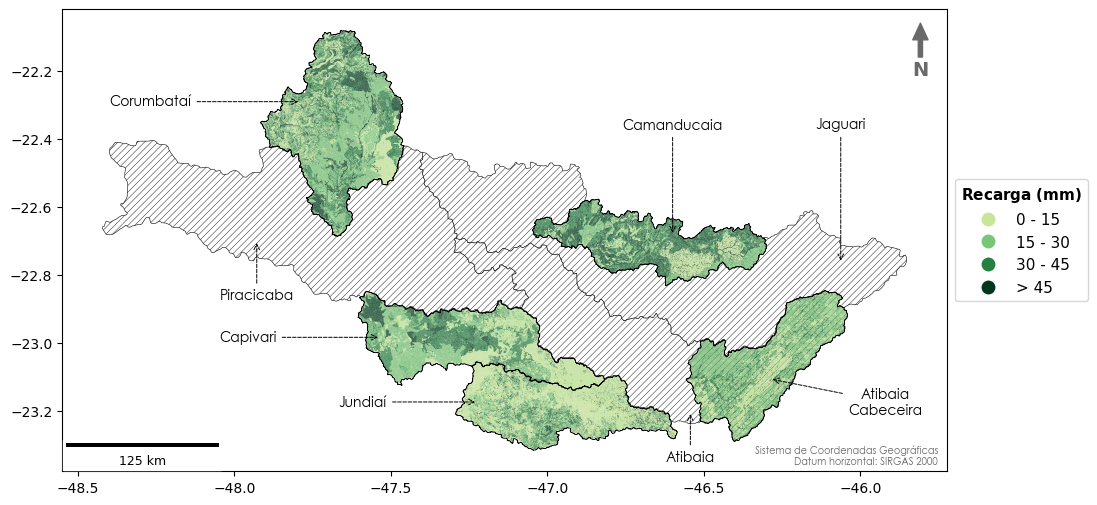

In [22]:
#Configurando a figura
fig, ax = plt.subplots(figsize=(12, 6))

lw = 0.5
######################################################################

#ATIBAIA CABECEIRA
atibaia_cabec_swat.plot(ax=ax, column='cl_atibaia', cmap=cmap, legend=True, legend_kwds={'title': '$\\bf{Recarga _ (mm)}$',
                                                                                    'title_fontsize': 11,
                                                                                    'loc': 'center left',
                                                                                    'bbox_to_anchor': (1.0, 0.5),
                                                                                    'fontsize': 11,
                                                                                    'fmt': '{:.1f}',
                                                                                    'frameon': True}, zorder=1, alpha=1.0)
#Limites Atibaia Cabeceira
limites_atibaia_cabeceira.boundary.plot(ax=ax, color='k', lw=lw, ls='-', label='Limites', zorder=2)


#CAMANDUCAIA E LIMITES
camanducaia_swat.plot(ax=ax, column='cl_camanducaia', cmap=cmap, zorder=1)
limites_camanducaia.boundary.plot(ax=ax, color='k', lw=lw, ls='-', label='Limites', zorder=2)


#CAPIVARI E LIMITES
capivari_swat.plot(ax=ax, column='cl_capivari', cmap=cmap, zorder=1)
limites_capivari.boundary.plot(ax=ax, color='k', lw=lw, ls='-', label='Limites', zorder=2)


#CORUMBATAÍ E LIMITES
corumbatai_swat.plot(ax=ax, column='cl_corumbatai', cmap=cmap, zorder=1)
limites_corumbatai.boundary.plot(ax=ax, color='k', lw=lw, ls='-', label='Limites', zorder=2)


#JUNDIAI E LIMITES
jundiai_swat.plot(ax=ax, column='cl_jundiai', cmap=cmap, zorder=1)
limites_jundiai.boundary.plot(ax=ax, color='k', lw=lw, ls='-', label='Limites', zorder=2)


#Limites da PCJ
# limites_pcj.boundary.plot(ax=ax, edgecolor='k', lw=lw, ls='-', label='Limites PCJ', zorder=0)    #facecolor='w', hatch='////',

plt.rcParams['hatch.linewidth'] = 0.3
subs_lw = 0.4
subs_hatch = '/////'
sub_pira.plot(ax=ax, facecolor='w', edgecolor='k', lw=subs_lw, hatch=subs_hatch, zorder=0)
sub_jaguari.plot(ax=ax, facecolor='w', edgecolor='k', lw=subs_lw, hatch=subs_hatch, zorder=0)
sub_atibaia.plot(ax=ax, facecolor='w', edgecolor='k', lw=subs_lw, hatch=subs_hatch, zorder=0)


#Plotando os LABELS das sub-bacias
arrowprops = dict(arrowstyle='->', color='k', lw=0.7, ls='--')
color, size, fontweight, fontname, alpha = 'k', 10, 'light', 'Century Gothic', 1.0

ax.annotate(text='Piracicaba', xy=(0.22, 0.50), xytext=(0.22, 0.38), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Capivari', xy=(0.36, 0.29), xytext=(0.21, 0.29), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Jundiaí', xy=(0.47, 0.15), xytext=(0.34, 0.15), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Corumbataí', xy=(0.27, 0.8), xytext=(0.1, 0.8), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Camanducaia', xy=(0.69, 0.51), xytext=(0.69, 0.75), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Jaguari', xy=(0.88, 0.45), xytext=(0.88, 0.75), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Atibaia\nCabeceira', xy=(0.80, 0.20), xytext=(0.93, 0.15), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)
ax.annotate(text='Atibaia', xy=(0.71, 0.13), xytext=(0.71, 0.03), xycoords=ax.transAxes, color=color, size=size, fontweight=fontweight, fontname=fontname, alpha=alpha, va='center', ha='center', arrowprops=arrowprops)

#Texto SRC
plt.text(0.99, 0.01, 'Sistema de Coordenadas Geográficas\nDatum horizontal: SIRGAS 2000', transform=ax.transAxes, va='bottom', ha='right', color='k', fontsize=7, fontweight='light', fontname='Century Gothic', alpha=0.6)

#Seta do Norte
x, y, arrow_length = 0.97, 0.97, 0.10
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='dimgray', edgecolor='dimgray', width=3, headwidth=11),
            ha='center', va='center', fontsize=14, color='dimgray', weight='bold',
            xycoords=ax.transAxes)

#Escala cartográfica
scalebar = ScaleBar(distance_meters, location='lower left', font_properties={'size': 9})
ax.add_artist(scalebar)

#Salvando o mapa
plt.savefig(path_figuras + 'figura_2_2.png', facecolor='w', bbox_inches='tight', dpi=300)

#Visualizando o mapa
plt.show()

## Gráfico donuts

In [23]:
#Calculando a área em km^2 de recarga para cada classe --> ATIBAIA CABECEIRA
atb_0_15 = ((len(sub_atibaia_cabeceira.loc[(sub_atibaia_cabeceira['media'] > 0) & (sub_atibaia_cabeceira['media'] < 15)])) * (250 * 250) / 10 ** 6)
atb_15_30 = ((len(sub_atibaia_cabeceira.loc[(sub_atibaia_cabeceira['media'] > 15) & (sub_atibaia_cabeceira['media'] < 30)])) * (250 * 250) / 10 ** 6)
atb_30_45 = ((len(sub_atibaia_cabeceira.loc[(sub_atibaia_cabeceira['media'] > 30) & (sub_atibaia_cabeceira['media'] < 45)])) * (250 * 250) / 10 ** 6)
atb_45 = ((len(sub_atibaia_cabeceira.loc[(sub_atibaia_cabeceira['media'] > 45) & (sub_atibaia_cabeceira['media'] < 10000)])) * (250 * 250) / 10 ** 6)

#Criando uma lista vazia para posteriormente adicionar cada valor de área de recarga --> ATIBAIA CABECEIRA
lista_atb = []
lista_atb.append(atb_0_15)
lista_atb.append(atb_15_30)
lista_atb.append(atb_30_45)
lista_atb.append(atb_45)
#############################################################################

#Calculando a área em km^2 de recarga para cada classe --> CAMANDUCAIA
cmd_0_15 = ((len(sub_camanducaia.loc[(sub_camanducaia['media'] > 0) & (sub_camanducaia['media'] < 15)])) * (250 * 250) / 10 ** 6)
cmd_15_30 = ((len(sub_camanducaia.loc[(sub_camanducaia['media'] > 15) & (sub_camanducaia['media'] < 30)])) * (250 * 250) / 10 ** 6)
cmd_30_45 = ((len(sub_camanducaia.loc[(sub_camanducaia['media'] > 30) & (sub_camanducaia['media'] < 45)])) * (250 * 250) / 10 ** 6)
cmd_45 = ((len(sub_camanducaia.loc[(sub_camanducaia['media'] > 45) & (sub_camanducaia['media'] < 10000)])) * (250 * 250) / 10 ** 6)

#Criando uma lista vazia para posteriormente adicionar cada valor de área de recarga --> CAMANDUCAIA
lista_cmd = []
lista_cmd.append(cmd_0_15)
lista_cmd.append(cmd_15_30)
lista_cmd.append(cmd_30_45)
lista_cmd.append(cmd_45)
#############################################################################

#Calculando a área em km^2 de recarga para cada classe --> CAPIVARI
cpv_0_15 = ((len(sub_capivari.loc[(sub_capivari['media'] > 0) & (sub_capivari['media'] < 15)])) * (250 * 250) / 10 ** 6)
cpv_15_30 = ((len(sub_capivari.loc[(sub_capivari['media'] > 15) & (sub_capivari['media'] < 30)])) * (250 * 250) / 10 ** 6)
cpv_30_45 = ((len(sub_capivari.loc[(sub_capivari['media'] > 30) & (sub_capivari['media'] < 45)])) * (250 * 250) / 10 ** 6)
cpv_45 = ((len(sub_capivari.loc[(sub_capivari['media'] > 45) & (sub_capivari['media'] < 10000)])) * (250 * 250) / 10 ** 6)

#Criando uma lista vazia para posteriormente adicionar cada valor de área de recarga --> CAPIVARI
lista_cpv = []
lista_cpv.append(cpv_0_15)
lista_cpv.append(cpv_15_30)
lista_cpv.append(cpv_30_45)
lista_cpv.append(cpv_45)
#############################################################################


#Calculando a área em km^2 de recarga para cada classe --> CORUMBATAI
crb_0_15 = ((len(sub_corumbatai.loc[(sub_corumbatai['media'] > 0) & (sub_corumbatai['media'] < 15)])) * (250 * 250) / 10 ** 6)
crb_15_30 = ((len(sub_corumbatai.loc[(sub_corumbatai['media'] > 15) & (sub_corumbatai['media'] < 30)])) * (250 * 250) / 10 ** 6)
crb_30_45 = ((len(sub_corumbatai.loc[(sub_corumbatai['media'] > 30) & (sub_corumbatai['media'] < 45)])) * (250 * 250) / 10 ** 6)
crb_45 = ((len(sub_corumbatai.loc[(sub_corumbatai['media'] > 45) & (sub_corumbatai['media'] < 10000)])) * (250 * 250) / 10 ** 6)

#Criando uma lista vazia para posteriormente adicionar cada valor de área de recarga --> CORUMBATAI
lista_crb = []
lista_crb.append(crb_0_15)
lista_crb.append(crb_15_30)
lista_crb.append(crb_30_45)
lista_crb.append(crb_45)
#############################################################################


#Calculando a área em km^2 de recarga para cada classe --> JUNDIAI
jnd_0_15 = ((len(sub_jundiai.loc[(sub_jundiai['media'] > 0) & (sub_jundiai['media'] < 15)])) * (250 * 250) / 10 ** 6)
jnd_15_30 = ((len(sub_jundiai.loc[(sub_jundiai['media'] > 15) & (sub_jundiai['media'] < 30)])) * (250 * 250) / 10 ** 6)
jnd_30_45 = ((len(sub_jundiai.loc[(sub_jundiai['media'] > 30) & (sub_jundiai['media'] < 45)])) * (250 * 250) / 10 ** 6)
jnd_45 = ((len(sub_jundiai.loc[(sub_jundiai['media'] > 45) & (sub_jundiai['media'] < 10000)])) * (250 * 250) / 10 ** 6)

#Criando uma lista vazia para posteriormente adicionar cada valor de área de recarga --> JUNDIAI
lista_jnd = []
lista_jnd.append(jnd_0_15)
lista_jnd.append(jnd_15_30)
lista_jnd.append(jnd_30_45)
lista_jnd.append(jnd_45)
#############################################################################

#### Gráfico donuts

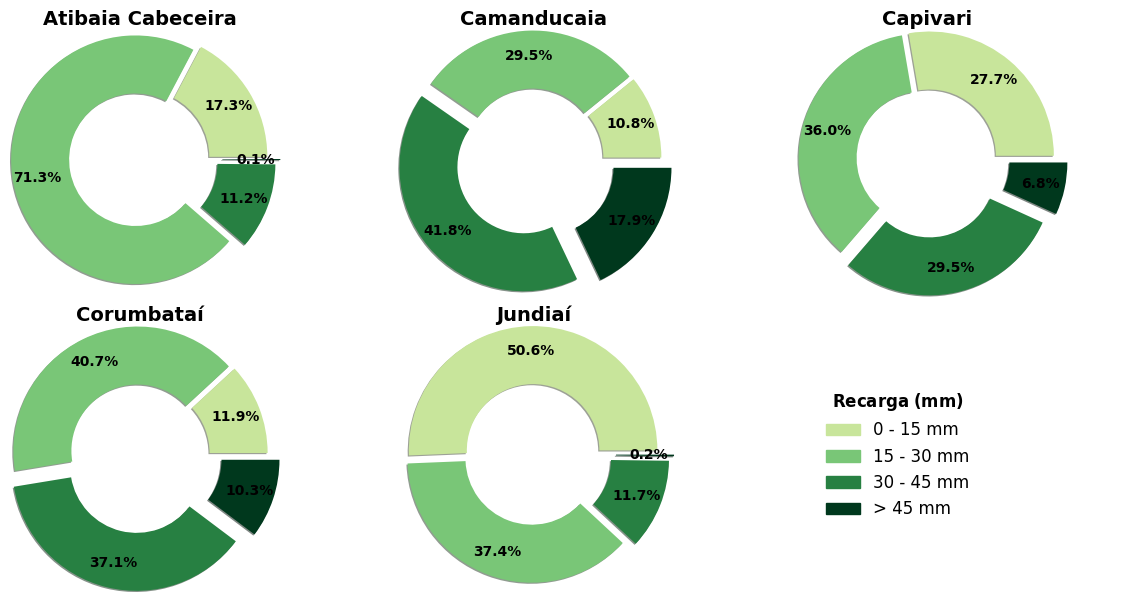

In [24]:
cm = 1/2.54    # para configurar o tamanho da figura em centímetros 
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(30*cm, 15*cm), layout='constrained')

#Configurando aspectos do gráfico donuts
cores_rec = ['#c8e59b', '#79c677', '#278042', '#00381d']    # cores para cada classe de recarga
explode = (0.05, 0.05, 0.15, 0.2)    # distância de cada "fatia" do gráfico
size = 0.7    # tamanho do círculo no centro do plot
edgecolor = None    # cor das bordas das "fatias" do plot
fontsize = 10    # tamanho da fonte dos rótulos do plot
title_fontsize = 14
ox = -0.01
oy = -0.01
shade = 0.7


#Sub-bacia Atibaia Cabeceira
ax1.pie(lista_atb, labels=None,
        colors=cores_rec,
        autopct='%1.1f%%',
        labeldistance=1.1,
        pctdistance=0.8,
        shadow=dict(ox=ox, oy=oy, shade=shade, edgecolor=None),
        radius=1.5,
        explode=explode,
        wedgeprops=dict(width=size, edgecolor=edgecolor),
        textprops={'fontsize': fontsize,
                   'fontweight': 'bold',
                   'color': 'k'})
ax1.set_title('Atibaia Cabeceira', fontsize=title_fontsize, color='k', weight='bold', pad=22.0)


#Sub-bacia Camanducaia
ax2.pie(lista_cmd, labels=None,
        colors=cores_rec,
        autopct='%1.1f%%',
        labeldistance=1.1,
        pctdistance=0.8,
        shadow=dict(ox=ox, oy=oy, shade=shade, edgecolor=None),
        radius=1.5,
        explode=explode,
        wedgeprops=dict(width=size, edgecolor=edgecolor),
        textprops={'fontsize': fontsize,
                   'fontweight': 'bold',
                   'color': 'k'})
ax2.set_title('Camanducaia', fontsize=title_fontsize, color='k', weight='bold', pad=22.0)


#Sub-bacia Capivari
ax3.pie(lista_cpv, labels=None,
        colors=cores_rec,
        autopct='%1.1f%%',
        labeldistance=1.1,
        pctdistance=0.8,
        shadow=dict(ox=ox, oy=oy, shade=shade, edgecolor=None),
        radius=1.5,
        explode=explode,
        wedgeprops=dict(width=size, edgecolor=edgecolor),
        textprops={'fontsize': fontsize,
                   'fontweight': 'bold',
                   'color': 'k'})
ax3.set_title('Capivari', fontsize=title_fontsize, color='k', weight='bold', pad=22.0)


#Sub-bacia Corumbataí
ax4.pie(lista_crb, labels=None,
        colors=cores_rec,
        autopct='%1.1f%%',
        labeldistance=1.1,
        pctdistance=0.8,
        shadow=dict(ox=ox, oy=oy, shade=shade, edgecolor=None),
        radius=1.5,
        explode=explode,
        wedgeprops=dict(width=size, edgecolor=edgecolor),
        textprops={'fontsize': fontsize,
                   'fontweight': 'bold',
                   'color': 'k'})
ax4.set_title('Corumbataí', fontsize=title_fontsize, color='k', weight='bold', pad=22.0)


#Sub-bacia Jundiaí
ax5.pie(lista_jnd, labels=None,
        colors=cores_rec,
        autopct='%1.1f%%',
        labeldistance=1.1,
        pctdistance=0.8,
        shadow=dict(ox=ox, oy=oy, shade=shade, edgecolor=None),
        radius=1.5,
        explode=explode,
        wedgeprops=dict(width=size, edgecolor=edgecolor),
        textprops={'fontsize': fontsize,
                   'fontweight': 'bold',
                   'color': 'k'})
ax5.set_title('Jundiaí', fontsize=title_fontsize, color='k', weight='bold', pad=22.0)


#Desabilitando o último subplot da figura
ax6.axis('off')


#Adicionando uma legenda manualmente
classe1 = mpatches.Patch(color='#c8e59b', label='0 - 15 mm')
classe2 = mpatches.Patch(color='#79c677', label='15 - 30 mm')
classe3 = mpatches.Patch(color='#278042', label='30 - 45 mm')
classe4 = mpatches.Patch(color='#00381d', label='> 45 mm')
plt.legend(handles=[classe1, classe2, classe3, classe4], title='$\\bf{Recarga _ (mm)}$', title_fontsize=12, fontsize=12, frameon=False, loc='center left', bbox_to_anchor=(0.2, 0.5))


#Salvando o mapa
plt.savefig(path_figuras + 'figura_2_4.png', facecolor='w', bbox_inches='tight', dpi=300)

#Visualizando
plt.show()

## Séries temporais de recarga

#### Dados do modelo SWAT

In [25]:
"""
Usar a lista de rótulos de colunas abaixo para melhorar o desempenho do processo de leitura das planilhas excel.
use_cols = ['LULC', 'YEAR', 'MON', 'GW_RCHGmm']
Usar com esse parâmetro: , usecols=use_cols
"""

tabela_hru_atibaia  = pd.read_excel(path_atibaia + 'hru.xlsx')
tabela_hru_camanducaia = pd.read_excel(path_camanducaia + 'hru.xlsx')
tabela_hru_capivari = pd.read_excel(path_capivari + 'hru.xlsx')
tabela_hru_corumbatai = pd.read_excel(path_corumbatai + 'hru.xlsx')
tabela_hru_jundiai = pd.read_excel(path_jundiai + 'hru.xlsx')

In [26]:
rch_hru_atibaia = tabela_hru_atibaia.copy(deep=True)
rch_hru_camanducaia = tabela_hru_camanducaia.copy(deep=True)
rch_hru_capivari = tabela_hru_capivari.copy(deep=True)
rch_hru_corumbatai = tabela_hru_corumbatai.copy(deep=True)
rch_hru_jundiai = tabela_hru_jundiai.copy(deep=True)

In [27]:
df_get_years = tabela_hru_atibaia.copy(deep=True)

#Tabela dinâmica, criando coluna de data, selecionando somente rec e renomeando
rch_hru_atibaia = pd.pivot_table(rch_hru_atibaia, index=['YEAR', 'MON'], values=['GW_RCHGmm'], aggfunc='mean', sort=False)
rch_hru_camanducaia = pd.pivot_table(rch_hru_camanducaia, index=['YEAR', 'MON'], values=['GW_RCHGmm'], aggfunc='mean', sort=False)
rch_hru_capivari = pd.pivot_table(rch_hru_capivari, index=['YEAR', 'MON'], values=['GW_RCHGmm'], aggfunc='mean', sort=False)
rch_hru_corumbatai = pd.pivot_table(rch_hru_corumbatai, index=['YEAR', 'MON'], values=['GW_RCHGmm'], aggfunc='mean', sort=False)
rch_hru_jundiai = pd.pivot_table(rch_hru_jundiai, index=['YEAR', 'MON'], values=['GW_RCHGmm'], aggfunc='mean', sort=False)

lista_dfs_subs = [rch_hru_atibaia, rch_hru_camanducaia, rch_hru_capivari, rch_hru_corumbatai, rch_hru_jundiai]
all_swat = pd.concat(lista_dfs_subs, axis=1)

all_swat.reset_index(['YEAR', 'MON'], inplace=True)

#Obtendo o primeiro e último ano do período
ano_inicial = df_get_years.loc[0, 'YEAR'].astype('str')
ano_final = df_get_years.iloc[-1, 4].astype('str')

#Criando uma coluna de datas
all_swat['Date'] = pd.date_range(start='01/01/' + ano_inicial, end='12/31/' + ano_final, freq='MS')

#Removendo colunas desnecessárias
all_swat.drop(['YEAR', 'MON'], axis=1, inplace=True)

all_swat.columns.values[0] = 'rch_atibaia'
all_swat.columns.values[1] = 'rch_camanducaia'
all_swat.columns.values[2] = 'rch_capivari'
all_swat.columns.values[3] = 'rch_corumbatai'
all_swat.columns.values[4] = 'rch_jundiai'

all_swat.set_index('Date', inplace=True)

In [28]:
print(f'Ano inicial: {ano_inicial}\nAno final: {ano_final}')

Ano inicial: 1985
Ano final: 2020


#### Dados do modelo MODFLOW

In [29]:
coluna_rec = ['rch_modflow (mm/dia)']

tabela_mod_atibaia = pd.read_csv(path_atibaia + 'serie_temp_mod.csv', usecols=coluna_rec)
tabela_mod_camanducaia = pd.read_csv(path_camanducaia + 'serie_temp_mod.csv', usecols=coluna_rec)
tabela_mod_capivari = pd.read_csv(path_capivari + 'serie_temp_mod.csv', usecols=coluna_rec)
tabela_mod_corumbatai = pd.read_csv(path_corumbatai + 'serie_temp_mod.csv', usecols=coluna_rec)
tabela_mod_jundiai = pd.read_csv(path_jundiai + 'serie_temp_mod.csv', usecols=coluna_rec)

In [30]:
lista_dfs_subs_mod = [tabela_mod_atibaia, tabela_mod_camanducaia, tabela_mod_capivari, tabela_mod_corumbatai, tabela_mod_jundiai]
all_mod = pd.concat(lista_dfs_subs_mod, axis=1)

In [31]:
all_mod['Date'] = pd.date_range(start='01/01/' + ano_inicial, end='12/31/' + ano_final, freq='MS')

all_mod.columns.values[0] = 'rch_atibaia'
all_mod.columns.values[1] = 'rch_camanducaia'
all_mod.columns.values[2] = 'rch_capivari'
all_mod.columns.values[3] = 'rch_corumbatai'
all_mod.columns.values[4] = 'rch_jundiai'

all_mod.set_index('Date', inplace=True)

all_mod

,rch_atibaia,rch_camanducaia,rch_capivari,rch_corumbatai,rch_jundiai
Date,,,,,
1985-01-01,61.816869,84.455702,36.453271,90.088636,18.630240
1985-02-01,23.797463,59.128613,12.475594,47.070435,8.829311
1985-03-01,60.618605,91.087655,59.278547,89.511506,36.398045
1985-04-01,12.069855,15.420279,41.977564,22.879867,3.116168
1985-05-01,1.752670,10.131855,17.286763,6.030221,7.465179
...,...,...,...,...,...
2020-08-01,0.358570,0.011020,2.371146,0.032263,2.644798
2020-09-01,0.064441,0.006301,0.671966,0.019590,0.313302
2020-10-01,0.563954,0.004076,0.583330,0.108817,0.149746


In [32]:
all_mod.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 432 entries, 1985-01-01 to 2020-12-01
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rch_atibaia      432 non-null    float64
 1   rch_camanducaia  432 non-null    float64
 2   rch_capivari     432 non-null    float64
 3   rch_corumbatai   432 non-null    float64
 4   rch_jundiai      432 non-null    float64
dtypes: float64(5)
memory usage: 20.2 KB


#### Subplots séries temporais - escala mensal

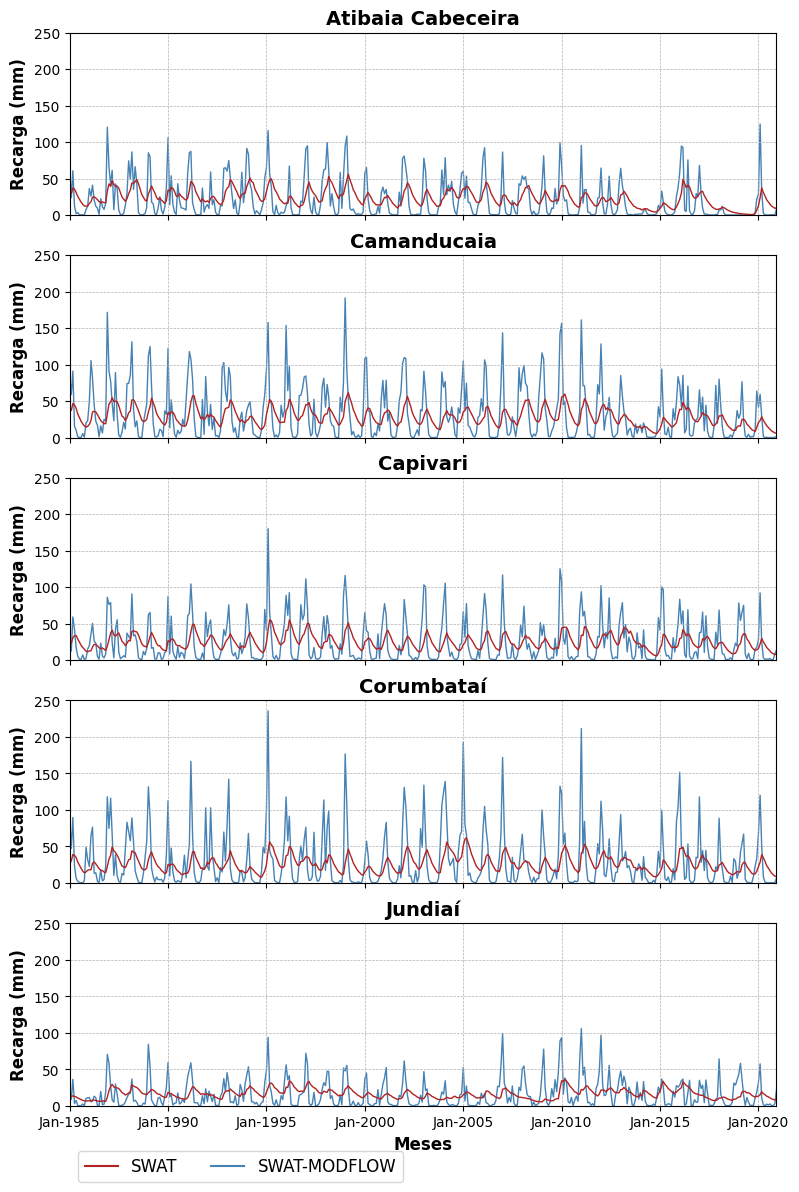

In [33]:
cm = 1/2.54    # para configurar o tamanho da figura em centímetros
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(20*cm, 30*cm), layout='constrained', sharex=True)

cor_swat = 'firebrick'    # 'mediumseagreen'
cor_mod = 'steelblue'    # 'navy'
lw = 1.0
ls = '-'
alpha = 1.0
fontsize = 12
title_fontsize = 14

upper_lim_yaxis = 250
data_minima = all_swat.index.min()
data_maxima = all_swat.index.max()

#Atibaia Cabeceira
ax1.plot(all_swat.index, all_swat['rch_atibaia'], color=cor_swat, lw=lw, ls=ls, alpha=alpha, label='SWAT', zorder=2)
ax1.plot(all_mod.index, all_mod['rch_atibaia'], color=cor_mod, lw=lw, ls=ls, alpha=alpha, label='SWAT-MODFLOW', zorder=1)
ax1.set_ylabel('Recarga (mm)', fontsize=fontsize, weight='bold')
ax1.set_ylim(0, upper_lim_yaxis)
ax1.set_xlim(data_minima, data_maxima)
ax1.grid(True, lw=0.5, ls='--')
ax1.set_title('Atibaia Cabeceira', fontsize=title_fontsize, weight='bold')

#Camanducaia
ax2.plot(all_swat.index, all_swat['rch_camanducaia'], color=cor_swat, lw=lw, ls=ls, alpha=alpha, label='SWAT', zorder=2)
ax2.plot(all_mod.index, all_mod['rch_camanducaia'], color=cor_mod, lw=lw, ls=ls, alpha=alpha, label='SWAT-MODFLOW', zorder=1)
ax2.set_ylabel('Recarga (mm)', fontsize=fontsize, weight='bold')
ax2.set_ylim(0, upper_lim_yaxis)
ax2.set_xlim(data_minima, data_maxima)
ax2.grid(True, lw=0.5, ls='--')
ax2.set_title('Camanducaia', fontsize=title_fontsize, weight='bold')

#Capivari
ax3.plot(all_swat.index, all_swat['rch_capivari'], color=cor_swat, lw=lw, ls=ls, alpha=alpha, label='SWAT', zorder=2)
ax3.plot(all_mod.index, all_mod['rch_capivari'], color=cor_mod, lw=lw, ls=ls, alpha=alpha, label='SWAT-MODFLOW', zorder=1)
ax3.set_ylabel('Recarga (mm)', fontsize=fontsize, weight='bold')
ax3.set_ylim(0, upper_lim_yaxis)
ax3.set_xlim(data_minima, data_maxima)
ax3.grid(True, lw=0.5, ls='--')
ax3.set_title('Capivari', fontsize=title_fontsize, weight='bold')

#Corumbataí
ax4.plot(all_swat.index, all_swat['rch_corumbatai'], color=cor_swat, lw=lw, ls=ls, alpha=alpha, label='SWAT', zorder=2)
ax4.plot(all_mod.index, all_mod['rch_corumbatai'], color=cor_mod, lw=lw, ls=ls, alpha=alpha, label='SWAT-MODFLOW', zorder=1)
ax4.set_ylabel('Recarga (mm)', fontsize=fontsize, weight='bold')
ax4.set_ylim(0, upper_lim_yaxis)
ax4.set_xlim(data_minima, data_maxima)
ax4.grid(True, lw=0.5, ls='--')
ax4.set_title('Corumbataí', fontsize=title_fontsize, weight='bold')

#Jundiaí
ax5.plot(all_swat.index, all_swat['rch_jundiai'], color=cor_swat, lw=lw, ls=ls, alpha=alpha, label='SWAT', zorder=2)
ax5.plot(all_mod.index, all_mod['rch_jundiai'], color=cor_mod, lw=lw, ls=ls, alpha=alpha, label='SWAT-MODFLOW', zorder=1)
ax5.set_ylabel('Recarga (mm)', fontsize=fontsize, weight='bold')
ax5.set_xlabel('Meses', fontsize=fontsize, weight='bold')
ax5.set_ylim(0, upper_lim_yaxis)
ax5.set_xlim(data_minima, data_maxima)
ax5.grid(True, lw=0.5, ls='--')
ax5.set_title('Jundiaí', fontsize=title_fontsize, weight='bold')


#Configurando os rótulos dos ticks de datas
#Os ticks principais a cada x anos (base) e mostrando o mês especificado por meio do argumento "month"
ax5.xaxis.set_major_locator(mdates.YearLocator(base=5, month=1))    # ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
#O texto no eixo x será mostrado no formato 'mm-YYYY'
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))


#Legenda
leg5 = ax5.legend(loc='upper left', bbox_to_anchor=(0, -0.2), fontsize=12, alignment='left', ncols=2, frameon=True)

for line in leg5.get_lines():
    line.set_linewidth(1.5)


#Salvando o plot
plt.savefig(path_figuras + 'figura_2_5.png', facecolor='w', bbox_inches='tight', dpi=300)

#Visualizando o plot
plt.show()

In [34]:
metricas_swat_mensal = all_swat.describe()
metricas_mod_mensal = all_mod.describe()

print(f'Métricas recarga mensal - modelo SWAT:\n\n{round(metricas_swat_mensal, 1)} \n\n\n Métricas recarga mensal - modelo MODFLOW:\n\n{round(metricas_mod_mensal, 1)}')

Métricas recarga mensal - modelo SWAT:

       rch_atibaia  rch_camanducaia  rch_capivari  rch_corumbatai  rch_jundiai
count        432.0            432.0         432.0           432.0        432.0
mean          23.8             28.8          25.2            26.1         16.5
std           11.4             11.7           9.7            10.9          6.4
min            0.6              5.6           5.8             7.5          5.4
25%           15.4             20.2          17.4            17.8         11.4
50%           22.3             27.4          23.7            24.3         16.0
75%           31.9             36.9          32.2            33.5         20.7
max           56.0             61.5          55.2            61.5         36.3 


 Métricas recarga mensal - modelo MODFLOW:

       rch_atibaia  rch_camanducaia  rch_capivari  rch_corumbatai  rch_jundiai
count        432.0            432.0         432.0           432.0        432.0
mean          20.8             32.4         

#### Escala anual

In [35]:
all_swat.head()

,rch_atibaia,rch_camanducaia,rch_capivari,rch_corumbatai,rch_jundiai
Date,,,,,
1985-01-01,32.663410,37.731139,26.442645,25.625447,15.017031
1985-02-01,29.333265,37.203878,23.332568,30.104569,12.750176
1985-03-01,37.029444,46.619813,30.886912,38.727879,13.699745
1985-04-01,35.525552,44.731264,33.401957,37.480483,12.882594
1985-05-01,31.003814,40.087614,33.790759,34.577666,12.147768


In [36]:
# print(all_swat.to_string())

In [37]:
all_swat_anual = all_swat.copy(deep=True)
all_swat_anual = all_swat_anual.resample('YE').sum()

all_swat_anual

,rch_atibaia,rch_camanducaia,rch_capivari,rch_corumbatai,rch_jundiai
Date,,,,,
1985-12-31,281.714951,353.218413,278.684520,300.403869,123.275485
1986-12-31,246.713508,321.742137,203.120228,243.200872,86.834977
1987-12-31,404.006603,485.355741,370.718143,394.706810,263.360053
1988-12-31,413.661219,424.473510,352.818581,355.061616,252.621490
1989-12-31,310.510576,388.314442,275.951878,304.220616,200.558059
1990-12-31,346.318718,298.454103,261.796838,220.427788,153.870337
1991-12-31,345.592954,447.522624,372.182200,316.271945,226.464867
1992-12-31,248.552238,316.135173,286.996700,308.350634,161.167029
1993-12-31,415.151782,406.164972,288.333481,301.373679,212.608331


In [38]:
all_mod.head()

,rch_atibaia,rch_camanducaia,rch_capivari,rch_corumbatai,rch_jundiai
Date,,,,,
1985-01-01,61.816869,84.455702,36.453271,90.088636,18.630240
1985-02-01,23.797463,59.128613,12.475594,47.070435,8.829311
1985-03-01,60.618605,91.087655,59.278547,89.511506,36.398045
1985-04-01,12.069855,15.420279,41.977564,22.879867,3.116168
1985-05-01,1.752670,10.131855,17.286763,6.030221,7.465179


In [39]:
all_mod_anual = all_mod.copy(deep=True)
all_mod_anual = all_mod_anual.resample('YE').sum()

all_mod_anual

,rch_atibaia,rch_camanducaia,rch_capivari,rch_corumbatai,rch_jundiai
Date,,,,,
1985-12-31,183.401521,310.655553,200.707929,341.118195,99.044089
1986-12-31,322.946636,563.920024,288.282519,357.872956,162.080865
1987-12-31,307.332727,477.339424,344.188973,470.024601,165.494139
1988-12-31,369.326935,467.226647,286.271080,400.890146,115.624676
1989-12-31,291.632572,421.364934,211.109158,317.120928,216.464667
1990-12-31,290.256737,334.898233,238.268015,250.198111,156.389051
1991-12-31,308.403126,560.252558,396.590748,478.817810,236.837216
1992-12-31,276.177524,411.367351,264.348370,345.248478,150.063389
1993-12-31,374.323057,365.489623,268.438324,285.287569,194.383190


#### Subplots séries temporais - escala anual

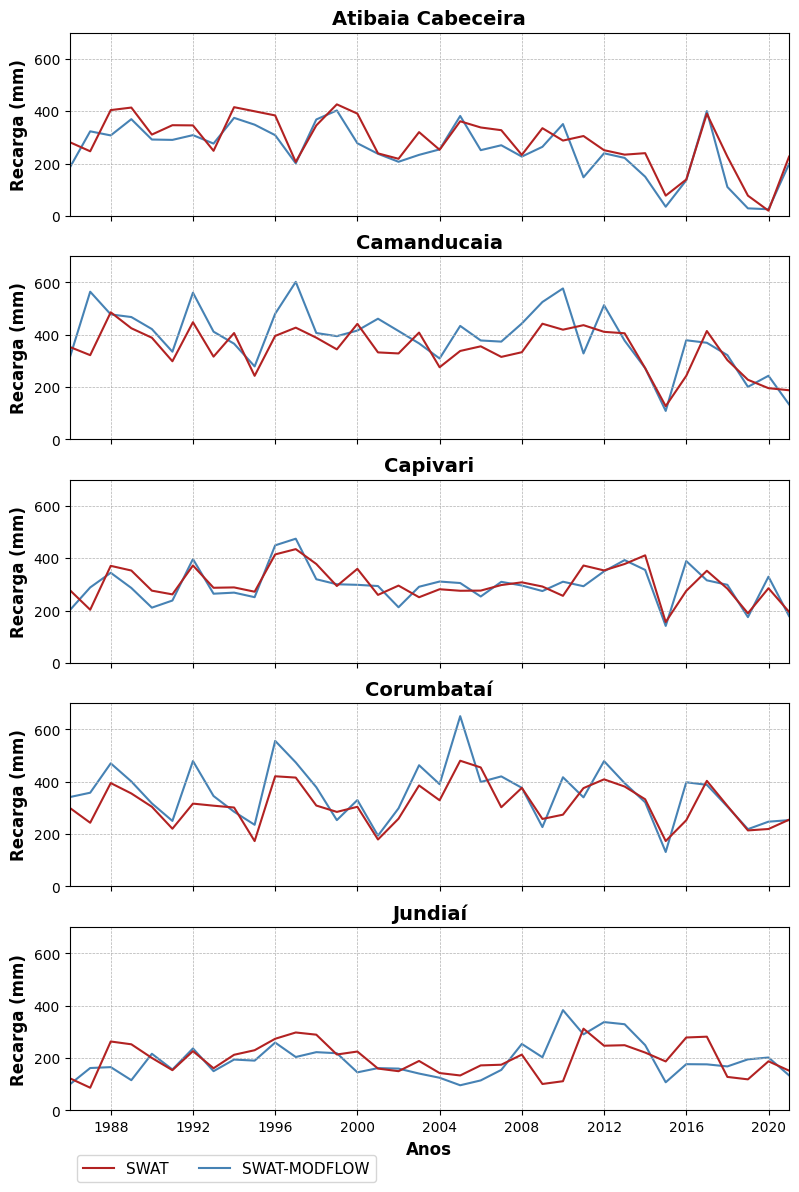

In [40]:
cm = 1/2.54    # para configurar o tamanho da figura em centímetros
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(20*cm, 30*cm), layout='constrained', sharex=True)

cor_swat = 'firebrick'    # 'mediumseagreen'
cor_mod = 'steelblue'    # 'navy'
lw = 1.5
ls = '-'
alpha = 1.0
fontsize = 12
title_fontsize = 14

upper_lim_yaxis = 700
data_minima2 = all_swat_anual.index.min()
data_maxima2 = all_swat_anual.index.max()

#Atibaia Cabeceira
ax1.plot(all_swat_anual.index, all_swat_anual['rch_atibaia'], color=cor_swat, lw=lw, ls=ls, alpha=alpha, label='SWAT', zorder=2)
ax1.plot(all_mod_anual.index, all_mod_anual['rch_atibaia'], color=cor_mod, lw=lw, ls=ls, alpha=alpha, label='SWAT-MODFLOW', zorder=1)
ax1.set_ylabel('Recarga (mm)', fontsize=fontsize, weight='bold')
ax1.set_ylim(0, upper_lim_yaxis)
ax1.set_xlim(data_minima2, data_maxima2)
ax1.grid(True, lw=0.5, ls='--')
ax1.set_title('Atibaia Cabeceira', fontsize=title_fontsize, weight='bold')

#Camanducaia
ax2.plot(all_swat_anual.index, all_swat_anual['rch_camanducaia'], color=cor_swat, lw=lw, ls=ls, alpha=alpha, label='SWAT', zorder=2)
ax2.plot(all_mod_anual.index, all_mod_anual['rch_camanducaia'], color=cor_mod, lw=lw, ls=ls, alpha=alpha, label='SWAT-MODFLOW', zorder=1)
ax2.set_ylabel('Recarga (mm)', fontsize=fontsize, weight='bold')
ax2.set_ylim(0, upper_lim_yaxis)
ax2.set_xlim(data_minima2, data_maxima2)
ax2.grid(True, lw=0.5, ls='--')
ax2.set_title('Camanducaia', fontsize=title_fontsize, weight='bold')

#Capivari
ax3.plot(all_swat_anual.index, all_swat_anual['rch_capivari'], color=cor_swat, lw=lw, ls=ls, alpha=alpha, label='SWAT', zorder=2)
ax3.plot(all_mod_anual.index, all_mod_anual['rch_capivari'], color=cor_mod, lw=lw, ls=ls, alpha=alpha, label='SWAT-MODFLOW', zorder=1)
ax3.set_ylabel('Recarga (mm)', fontsize=fontsize, weight='bold')
ax3.set_ylim(0, upper_lim_yaxis)
ax3.set_xlim(data_minima2, data_maxima2)
ax3.grid(True, lw=0.5, ls='--')
ax3.set_title('Capivari', fontsize=title_fontsize, weight='bold')

#Corumbataí
ax4.plot(all_swat_anual.index, all_swat_anual['rch_corumbatai'], color=cor_swat, lw=lw, ls=ls, alpha=alpha, label='SWAT', zorder=2)
ax4.plot(all_mod_anual.index, all_mod_anual['rch_corumbatai'], color=cor_mod, lw=lw, ls=ls, alpha=alpha, label='SWAT-MODFLOW', zorder=1)
ax4.set_ylabel('Recarga (mm)', fontsize=fontsize, weight='bold')
ax4.set_ylim(0, upper_lim_yaxis)
ax4.set_xlim(data_minima2, data_maxima2)
ax4.grid(True, lw=0.5, ls='--')
ax4.set_title('Corumbataí', fontsize=title_fontsize, weight='bold')

#Jundiaí
ax5.plot(all_swat_anual.index, all_swat_anual['rch_jundiai'], color=cor_swat, lw=lw, ls=ls, alpha=alpha, label='SWAT', zorder=2)
ax5.plot(all_mod_anual.index, all_mod_anual['rch_jundiai'], color=cor_mod, lw=lw, ls=ls, alpha=alpha, label='SWAT-MODFLOW', zorder=1)
ax5.set_ylabel('Recarga (mm)', fontsize=fontsize, weight='bold')
ax5.set_xlabel('Anos', fontsize=fontsize, weight='bold')
ax5.set_ylim(0, upper_lim_yaxis)
ax5.set_xlim(data_minima2, data_maxima2)
ax5.grid(True, lw=0.5, ls='--')
ax5.set_title('Jundiaí', fontsize=title_fontsize, weight='bold')


#Legenda
leg5 = ax5.legend(loc='upper left', bbox_to_anchor=(0, -0.2), fontsize=11, alignment='left', ncols=2, frameon=True)

for line in leg5.get_lines():
    line.set_linewidth(1.5)


#Salvando o plot
plt.savefig(path_figuras + 'figura_2_6.png', facecolor='w', bbox_inches='tight', dpi=300)

#Visualizando o plot
plt.show()

In [41]:
metricas_swat_anual = all_swat_anual.describe()
metricas_mod_anual = all_mod_anual.describe()

print(f'Métricas recarga anual - modelo SWAT:\n\n{round(metricas_swat_anual, 0)} \n\n\n Métricas recarga anual - modelo MODFLOW:\n\n{round(metricas_mod_anual, 0)}')

Métricas recarga anual - modelo SWAT:

       rch_atibaia  rch_camanducaia  rch_capivari  rch_corumbatai  rch_jundiai
count         36.0             36.0          36.0            36.0         36.0
mean         285.0            346.0         302.0           313.0        198.0
std          100.0             84.0          65.0            79.0         61.0
min           20.0            127.0         156.0           173.0         87.0
25%          234.0            302.0         274.0           257.0        152.0
50%          296.0            349.0         288.0           306.0        195.0
75%          350.0            412.0         355.0           378.0        248.0
max          426.0            485.0         435.0           480.0        312.0 


 Métricas recarga anual - modelo MODFLOW:

       rch_atibaia  rch_camanducaia  rch_capivari  rch_corumbatai  rch_jundiai
count         36.0             36.0          36.0            36.0         36.0
mean         250.0            389.0         29

## Estatística utilizando-se a biblioteca Hydroeval

In [43]:
ref = all_swat['rch_corumbatai']
comp = all_mod['rch_corumbatai']

nse = he.evaluator(he.nse, comp, ref)

kge, r, alpha, beta = he.evaluator(he.kge, comp, ref)

# print('NSE:', round(nse[0], 2))
dash = '--'
n = 20
print(f'{dash * n} \nKGE: {round(kge[0], 2)} \nr: {round(r[0], 2)} \nα: {round(alpha[0], 2)} \nβ: {round(beta[0], 2)} \n{dash * n}')    # Note, all four values KGE, r, α, β are returned, in this order.

---------------------------------------- 
KGE: -1.66 
r: 0.36 
α: 3.58 
β: 1.13 
----------------------------------------
